# Constructions for a bivariate beta distribution

**Authors:** Ingram Olkin a , Thomas A. Trikalinos b,

In this paper, the authors build a possible bivariate form for beta distribution such that its marginal is beta distribution. Other aproaches from other researchers are cited. This construction allows the correlation between the variables range from -1 to 1. 

In [1]:
%matplotlib inline

import numpy as np
from scipy.special import gamma
from scipy.integrate import quad

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

The construction can be summarized as follows: 

1. Let $U_{11}, U_{10}, U_{01}$ have the Dirichlet distribution with parameter $\alpha_{ij} \ge 0$, and $\alpha  = (\alpha_{11}, \alpha_{10}, \alpha_{01} , \alpha_{00})$.

2. Define $X = U_{11} + U_{10}, Y = U_{11} + U_{01}$.

3. The joint ditribution of $(X,Y)$ with domain $\Omega = \{u_{11} : \max(0, x + y - 1) < u_{11} < \min(x, y)\}$ is bivariate beta. 

Remarks: 

- Non closed form; 
- Density symmetric in $(x, \alpha_{10})$ and $(y, \alpha_{01})$. 

In [2]:
alpha = np.array([4,2,2,2])
# Generating Dirichlet
U = np.random.dirichlet(alpha, size = 10000)
# Calculating X and Y
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]

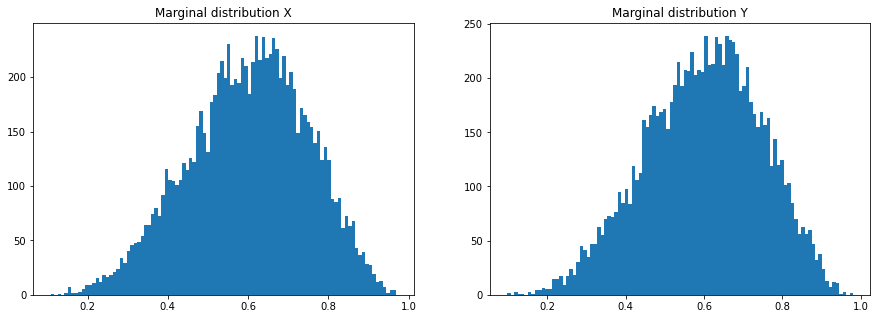

In [3]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].hist(X, 100)
ax[1].hist(Y, 100)
ax[0].set_title('Marginal distribution X')
ax[1].set_title('Marginal distribution Y')
plt.show()

In [4]:
np.corrcoef(X,Y)

array([[1.        , 0.17532219],
       [0.17532219, 1.        ]])

We now write the function as described in the article. 

In [14]:
gen_beta = lambda alpha: gamma(alpha).prod()/gamma(alpha.sum())

#def bivariate_beta_pdf(x,y,alpha): 
    
#    c = gen_beta(alpha)
    
#    lb = max(0,x+y-1)+0.00001
#    ub = min(x,y)-0.00001
    
#    f_u = lambda u: (u**(alpha[0]-1))*((x-u)**(alpha[1]-1))*((y-u)**(alpha[2]-1))*((1-x-y+u)**(alpha[3]-1))
    
#    return quad(f_u, lb, ub)

def bivariate_beta_pdf(x,y,alpha): 
    
    c = gen_beta(alpha)
    
    lb = max(0,x+y-1)
    ub = min(x,y)
    
    def f_u(u):     
        if x == 0 or y == 0: return 0        
        return np.exp((alpha[0]-1)*np.log(u) + (alpha[1]-1)*np.log(x-u) + (alpha[2]-1)*np.log(y-u) + (alpha[3]-1)*np.log1p(-x-y+u))
            
    return quad(f_u, lb, ub)

In [12]:
alphas = np.array([[1,1,1,1], 
                   [3,3,3,3],
                   [2,4,2,2],
                   [2,2,4,2],
                   [2,2,2,4],
                   [4,2,4,1],
                   [2,2,2,.5],
                   [1,1,1,0.5],
                   [10,1,1,10]
                 ])

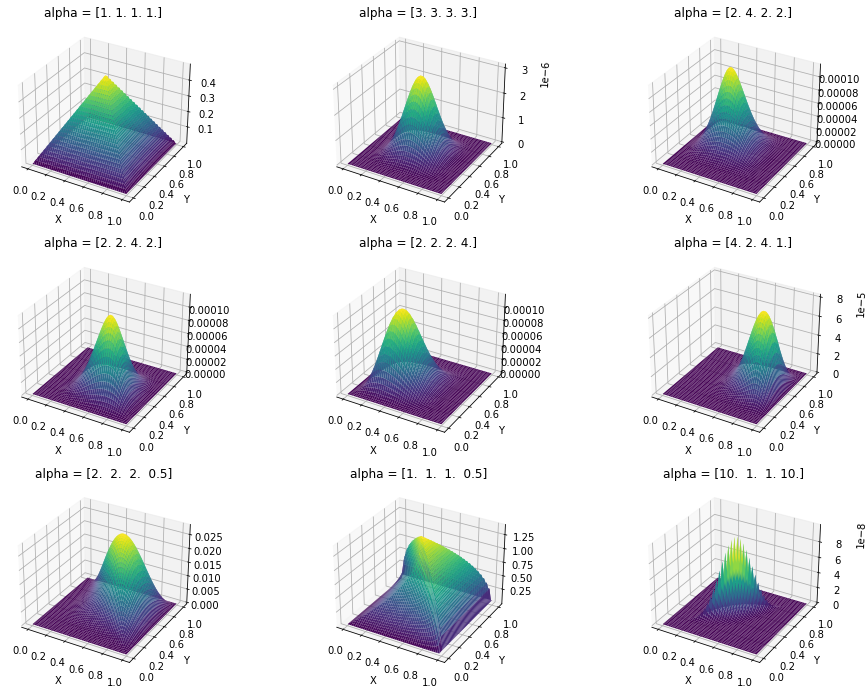

In [15]:
x_values = y_values = np.linspace(0.001, 0.999, 50)
X, Y = np.meshgrid(x_values,y_values)

fig = plt.figure(figsize = (16, 12))

Z = np.zeros_like(X)

for k, alpha in enumerate(alphas): 

    for i,x in enumerate(x_values): 
        for j,y in enumerate(y_values): 
            Z[i,j] = bivariate_beta_pdf(x, y, alpha)[0]
            
    ax = fig.add_subplot(3, 3, k+1, projection='3d') 

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y');
    ax.set_title("alpha = {}".format(alpha));

plt.savefig("../../images/beta-distributions.png", bbox_inches='tight', dpi=300 )